In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras 
from keras.layers import TextVectorization, Input, Embedding, concatenate, Conv1D, GlobalMaxPooling1D, RepeatVector, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.models import Model

from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import tensorflow as tf
tf.keras.utils.set_random_seed(123)

Mounted at /content/drive


In [ ]:
trainDF = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UCI_Sentiment_Analysis/transformed_train.csv")
trainDF = trainDF[ trainDF["sentiment"] != -1 ]

testDF = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UCI_Sentiment_Analysis/transformed_test.csv")
testDF = testDF[ testDF["sentiment"] != -1 ]

In [ ]:
# Positve
trainDF[ trainDF["sentiment"] == 1 ].head(5)

,id,rating,sentiment,comment,posTag
1,1175,9,1,match|1|tag|team|table|match|bubba|ray|and|spi...,VERB|NUM|NOUN|NOUN|NOUN|NOUN|NOUN|NOUN|CCONJ|N...
2,4383,9,1,attention|spoiler|first|let|say|rob|roy|one|go...,NOUN|NOUN|ADV|VERB|VERB|VERB|NOUN|NUM|ADJ|NOUN...
3,10044,9,1,titanic|direct|james|cameron|present|fictional...,ADV|VERB|NOUN|NOUN|NOUN|ADJ|NOUN|NOUN|ADJ|NOUN...
4,4076,10,1,probably|hear|bit|new|disney|dub|miyazaki|clas...,ADV|VERB|NOUN|ADJ|NOUN|NOUN|NOUN|NOUN|NOUN|NOU...
5,2662,10,1,spoiler|begin|let|say|advantage|see|movie|big|...,NOUN|VERB|VERB|VERB|SCONJ|VERB|NOUN|ADJ|NOUN|C...


In [ ]:
# Negative
trainDF[ trainDF["sentiment"] == 0 ].head(5)

,id,rating,sentiment,comment,posTag
8,1930,4,0,some|praise|_atlantis|_the_lost_empire_|as|dis...,DET|VERB|NOUN|NOUN|ADP|PROPN|PROPN|NOUN|VERB|V...
9,1929,4,0,some|praise|atlantis|lose|empire|as|disney|adv...,DET|VERB|NOUN|VERB|NOUN|ADP|PROPN|PROPN|NOUN|V...
15,7726,1,0,warn|review|contain|plot|spoiler|though|nothin...,VERB|NOUN|NOUN|NOUN|NOUN|SCONJ|PRON|AUX|VERB|N...
16,2981,1,0,movie|recently|release|dvd|we|and|finally|get|...,NOUN|ADV|VERB|ADP|PRON|CCONJ|ADV|VERB|NOUN|VER...
21,1048,4,0,raise|victor|vargas|reviewyou|know|raise|victo...,VERB|NOUN|NOUN|NOUN|VERB|VERB|NOUN|NOUN|SCONJ|...


In [ ]:
MAX_VOCABULARY = 36000
MAX_SEQUENCE_LENGTH = 600

vectorize_text = TextVectorization(
    standardize = None,
    output_mode = 'int',
    output_sequence_length = MAX_SEQUENCE_LENGTH,
    max_tokens = MAX_VOCABULARY,
    split = lambda text : tf.strings.split(text, sep = '|')
    )

vectorize_text.adapt(trainDF["comment"])
vectorize_text.adapt(testDF["comment"])

In [ ]:
X_train = vectorize_text(trainDF["comment"]).numpy()
Y_train = trainDF["sentiment"].to_numpy()

X_test = vectorize_text(testDF["comment"]).numpy()
Y_test = testDF["sentiment"].to_numpy()

x_train, x_validation, y_train, y_validation = train_test_split(X_train, Y_train, test_size=0.1, random_state = 123)

In [ ]:
# Vectorized Comment Text
print("Vectorized Comment Text: {}".format(X_train.shape) )
print(X_train)

Vectorized Comment Text: (25000, 600)
[[  673   239  2976 ...  9723    76  4975]
 [  588   552    45 ...   380     7   532]
 [ 2250   223   498 ...   270   483  2250]
 ...
 [ 6892 10274    71 ...     0     0     0]
 [  503   442     8 ...     0     0     0]
 [    3   340     6 ...     0     0     0]]


In [ ]:
text_input = Input( shape = (X_train.shape[1],) )
text_embd = Embedding(
    input_dim = np.max(X_train) + 1, 
    output_dim = 64, 
    input_length = X_train.shape[1]
    )(text_input)

conv_layer_1 = Conv1D(20, kernel_size=2, padding='same', activation='relu')(text_embd)
pool_1 = GlobalMaxPooling1D()(conv_layer_1)

conv_layer_2 = Conv1D(20, kernel_size=3, padding='same', activation='relu')(text_embd)
pool_2 = GlobalMaxPooling1D()(conv_layer_2)

conv_layer_3 = Conv1D(20, kernel_size=4, padding='same', activation='relu')(text_embd)
pool_3 = GlobalMaxPooling1D()(conv_layer_3)

conv_layer_4 = Conv1D(20, kernel_size=5, padding='same', activation='relu')(text_embd)
pool_4 = GlobalMaxPooling1D()(conv_layer_4)

concat_layer = concatenate( [pool_1, pool_2, pool_3, pool_4] , axis=-1)

dropout = Dropout(0.33)(concat_layer)

output_layer = Dense(2, activation='softmax')(dropout)

model = Model(inputs = text_input, outputs = output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 600, 64)      2304000     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 600, 20)      2580        ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 600, 20)      3860        ['embedding[0][0]']              
                                                                                              

In [ ]:
history = model.fit(
    x_train, 
    y_train,
    epochs = 100,
    validation_data = ( x_validation , y_validation ),
    callbacks = [ EarlyStopping(patience = 2, monitor = 'val_loss') ],
    shuffle = False,
    verbose = 2
    )

Epoch 1/100
704/704 - 14s - loss: 0.4541 - acc: 0.7804 - val_loss: 0.3127 - val_acc: 0.8644 - 14s/epoch - 20ms/step
Epoch 2/100
704/704 - 5s - loss: 0.2483 - acc: 0.8986 - val_loss: 0.2836 - val_acc: 0.8848 - 5s/epoch - 8ms/step
Epoch 3/100
704/704 - 6s - loss: 0.1338 - acc: 0.9516 - val_loss: 0.3053 - val_acc: 0.8760 - 6s/epoch - 8ms/step
Epoch 4/100
704/704 - 6s - loss: 0.0619 - acc: 0.9815 - val_loss: 0.3645 - val_acc: 0.8736 - 6s/epoch - 8ms/step


In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/UCI_Sentiment_Analysis/Models/text_cnn.h5'
# model = keras.models.load_model(model_path)

782/782 [==============================] - 2s 3ms/step


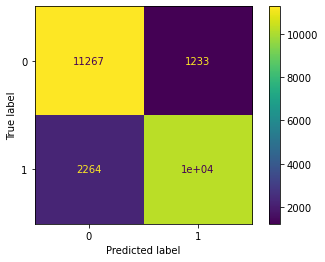

In [ ]:
y_predict = [ score.argmax() for score in history.model.predict(X_test) ]

matrix = confusion_matrix( Y_test, y_predict )

ConfusionMatrixDisplay(matrix).plot()

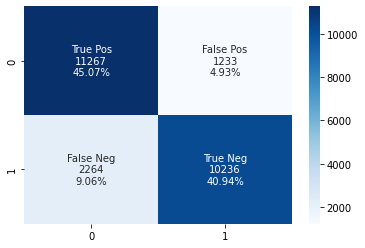

In [ ]:
group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
history.model.evaluate(X_test, Y_test)

print( classification_report(Y_test, y_predict, target_names=['Negative', 'Positive']) )

782/782 [==============================] - 3s 4ms/step - loss: 0.3907 - acc: 0.8601
              precision    recall  f1-score   support

    Negative       0.83      0.90      0.87     12500
    Positive       0.89      0.82      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



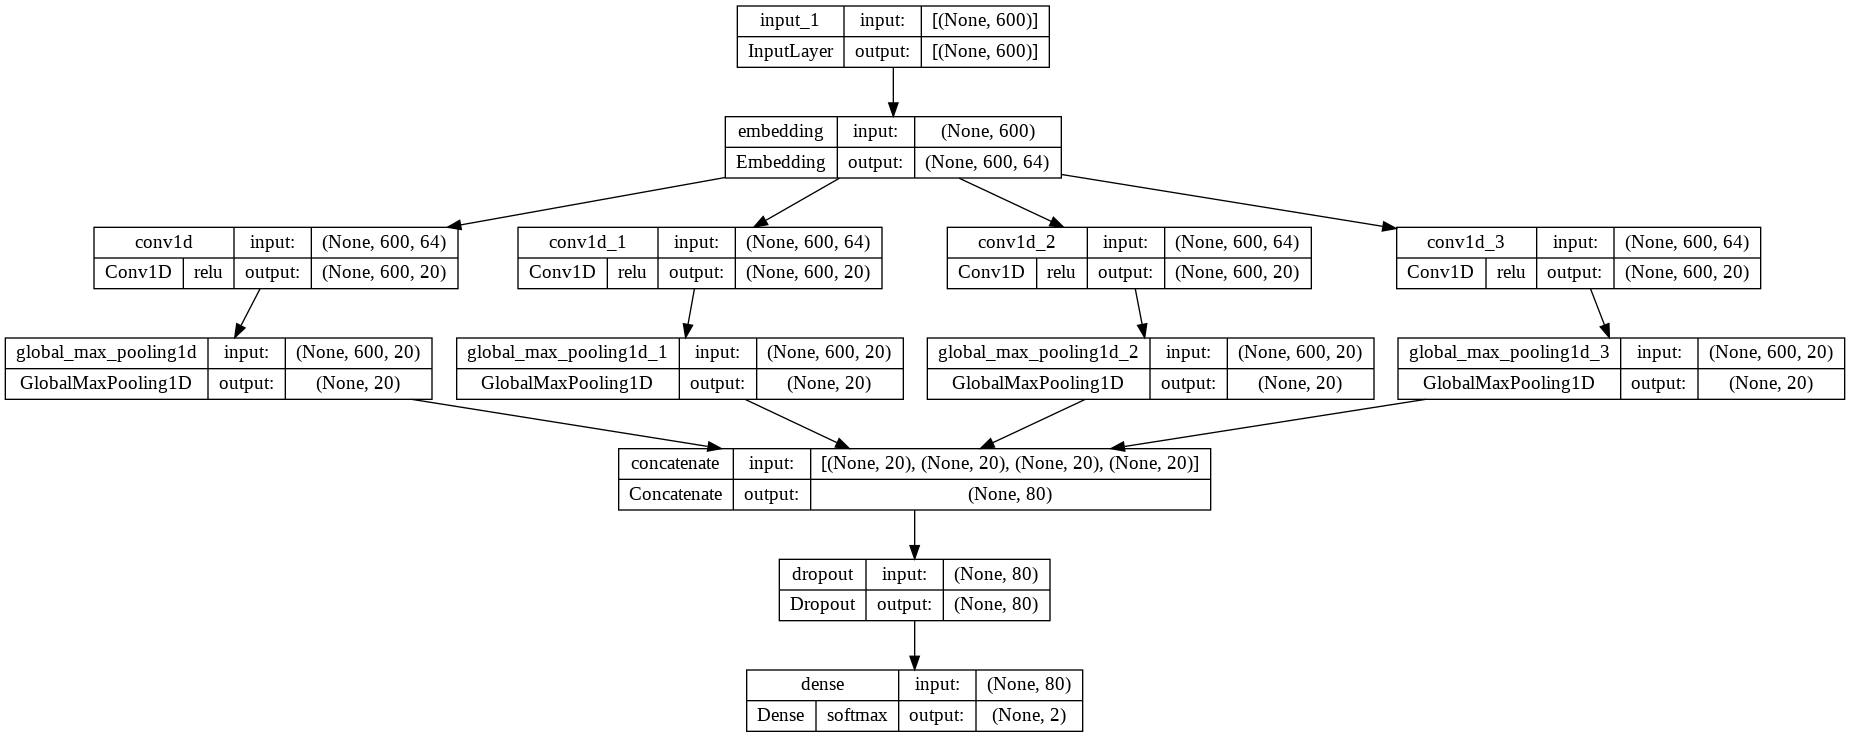

In [ ]:
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

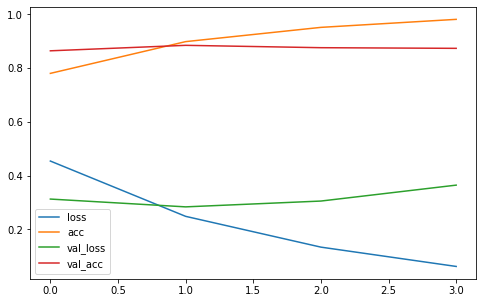

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [ ]:
model.save(model_path, overwrite=False)